In [1]:
import jieba
import jieba.analyse
import numpy as np
import re
import matplotlib.pyplot as plt
#import nltk
from snownlp import SnowNLP
from selenium import webdriver
from nltk.tokenize import sent_tokenize
import time

In [2]:
def loadScores():
    """
         从QS_Scores.txt中读取每个大学的评分，返回嵌套的列表数据
    """
    fileContent = []
    lineCount = 0
    f = open("QS_Scores.txt", "r")
    tempContent = []
    for line in f:
        tempContent.append(line.strip('\n'))
        lineCount += 1
        if lineCount % 9 == 0:   #行数求余9为0，意味着一个大学的9行信息读取完毕
            fileContent.append(tempContent)
            tempContent = []
    f.close()
    print("QS_Scores loaded successfully!")
    return fileContent

In [3]:
def loadComments():
    """
        从Comments.txt中读取爬下来的评论，返回一个字典，键值为大学名称，值为评论列表
    """
    fileContent = {}
    f = open("Comments.txt", "r", encoding="utf-8")
    key = ""
    for line in f:
        if line.startswith("##"):
            key = line[2:-1]
            fileContent[key] = []
            continue
        fileContent[key].append(line[1:-1])
                
    f.close()
    print("Comments.txt loaded successfully!")
    return fileContent

In [4]:
def loadStopWords():
    """
        从stopwords.txt中读取停词，并返回停词
    """
    f = open('stopwords.txt',"r")
    stopwords = f.read()
    f.close()
    return stopwords

In [5]:
def filterString(text):
    """
        筛选合格的爬虫语句
    """
    if re.search(r"http|SAT|GRE|GMAT|IELTS|TOEFL|#", text): #剔除网站链接和英语成绩相关
        return False
    if re.search(r"[a-zA-Z]*(\s+)[a-zA-Z]*",text): #剔除英文短语和句子（允许出现个别无空格单词）
        return False
    if re.match(r"[a-zA-Z]*[0-9(——)(#)(\:)(\[)(\])(\{)(\})(\=)(\-)(\.)(+)(-)(_)(?)(\s)]+[a-zA-Z]*",text): #剔除只由标点符号和数字空格组成的无意义字符
        return False
    if re.search(r"申请",text): #剔除含“申请”字样的内容
        return False
    return True

In [6]:
def filterAndFormat(text):
    """
         对爬下来的文本进行断句，并进行筛选
    """
    thisP = []
    for line in sent_tokenize(text):
        if filterString(line):
            thisP.append("#" + line + "\n")
    return thisP

In [7]:
def scrapingComments(universityList):
    """
         启动爬虫程序，传入参数为大学名称列表，将评论保存在Comments.txt中
    """
    baseURL = "https://www.zhihu.com/search?type=content&q="
    browser = webdriver.Chrome()
    #nltk.download('punkt')
    f = open("Comments.txt", "w", encoding ="utf-8")
    for universityName in universityList:
        buttonCount = 0
        usefulButton = 0
        browser.get(baseURL + universityName)
        f.write("##" + universityName + "\n")
        buttonCount = len(browser.find_elements_by_tag_name("button"))
        for i in range(buttonCount):
            button = browser.find_elements_by_tag_name("button")[i]
            i += 1 
            if button.text == "阅读全文":
                usefulButton += 1
                button.click()                     
                for p in browser.find_elements_by_css_selector(".RichContent-inner p"):
                    for t in filterAndFormat(p.text):
                        f.write(t)                 
                if usefulButton > 15:
                    break
                time.sleep(5)
                browser.refresh()
    f.close()
    browser.close()
    print("Comment.txt refreshed successfully!")

In [8]:
def preprocess(row, stopwords):
    row = re.sub('[a-zA-Z0-9]', '', row)
    seg_list = jieba.cut(row)
    segs = [word for word in seg_list if word not in stopwords]  # remove stopwords
    return ' '.join(segs) if segs else " "

In [9]:
def computeComments(comments, stopwords):
    """
         计算所有大学的评论得分，返回一个字典，键值为大学名称，值为评论得分
    """
    commentsScores = {}
    for key in comments.keys():
        commentsScores[key] = 0
        count = 0
        for comment in comments[key]:
            seg = preprocess(comment, stopwords)
            s1 = SnowNLP(seg)
            commentsScores[key] += s1.sentiments
            count += 1
        try:
            commentsScores[key] = commentsScores[key]*100 / count
        except ZeroDivisionError:
            commentsScores[key] = 0.5
    
    return commentsScores

In [10]:
def computeFinalScores(QSScores, commentsScores, percent):
    """
         根据评论得分的百分比计算所有大学的总分，返回一个字典，键值为大学名称，值为总分
    """
    finalScores = {}
    for universityFormal in QSScores[:20]:
        finalScores[universityFormal[1]] = 0
        for oneScore in universityFormal[2:]:
            finalScores[universityFormal[1]] += float(oneScore)
        finalScores[universityFormal[1]] = (finalScores[universityFormal[1]] * ( 100 - percent) / 7 + percent * commentsScores[universityFormal[1]]) / 100 
    return finalScores

In [11]:
def computeRanks(QSScores, commentsScores, universityList):
    """
        根据大学列表返回大学列表对应的排名，返回 一个字典，键为大学名称，值为排名列表
    """
    ranks = {}
    ranks[universityList[0]] = []
    ranks[universityList[1]] = []
    ranks[universityList[2]] = [] 
    for percent in range(0,110,10):       
        finalScores = computeFinalScores(QSScores,commentsScores,percent)
        #printFinalScores(finalScores,str(percent)) 
        sortedFinalScores = sorted(finalScores.items(), key = lambda x:x[1], reverse=True)
        i = 1  
        for universityName in sortedFinalScores:

            if universityName[0] == universityList[0]:
                ranks[universityList[0]].append(i)
            if universityName[0] == universityList[1]:
                ranks[universityList[1]].append(i)
            if universityName[0] == universityList[2]:
                ranks[universityList[2]].append(i)
            i += 1
    return ranks

In [12]:
def printFinalScores(finalScores,percent):
    """
        打印根据输入评论占比的列表
    """
    sortedFinalScores = sorted(finalScores.items(), key = lambda x:x[1], reverse=True)
    i =  1
    print("When comments is " + percent + "%, the final rank is: ")
    print("Rank:    University Name:                             Scores:")
    for item in sortedFinalScores:
        print("{0:<9}{1:45}{2:.2f}".format(i, item[0], item[1]))
        i += 1

In [13]:
def drawDiagram(QSScores, commentsScores):
    """
        画其中三个大学排名随评论得分占比变化的统计图
    """
    universityList = ["Imperial College London","Princeton University","National University of Singapore"]   
    ranks = computeRanks(QSScores, commentsScores, universityList)       
    plt.figure(figsize=(8,6))
    plt.plot(range(0, 110, 10), ranks[universityList[0]],"b-o", range(0, 110, 10), ranks[universityList[1]],"g-^", range(0, 110, 10), ranks[universityList[2]],"r-x")
    plt.xlim((0,110)) #设置x坐标取值范围
    plt.ylim((20,0)) #设置y坐标取值范围
    plt.xticks(np.arange(0,110,10)) #设置x坐标间隔
    plt.yticks(np.arange(1,20,1)) #设置y坐标间隔
    plt.xlabel('Comment Percent', size = 18) #设置x轴说明
    plt.ylabel('Ranks', size = 18) #设置y轴说明
    plt.title('Ranks of Three Universities with Different Comment Percent') #设置表格标题
    plt.legend(universityList, loc = 'lower right') #设置图线说明
    plt.show()
    plt.close()

In [14]:
QSScores = loadScores()
#universityList = [log[1] for log in QSScores]
#scrapingComments(universityList[:20])

QS_Scores loaded successfully!


In [15]:
comments = loadComments()

Comments.txt loaded successfully!


In [16]:
commentsScores = computeComments(comments,loadStopWords())

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lixuy\AppData\Local\Temp\jieba.cache
Loading model cost 0.634 seconds.
Prefix dict has been built succesfully.


In [17]:
percent  = input("Please input the percent of the comments: ")

Please input the percent of the comments: 23


In [19]:
finalScores = computeFinalScores(QSScores,commentsScores,float(percent))

In [20]:
printFinalScores(finalScores,str(percent))

When comments is 23%, the final rank is: 
Rank:    University Name:                             Scores:
1        Massachusetts Institute of Technology        94.83
2        University of Oxford                         92.64
3        Imperial College London                      92.43
4        California Institute of Technology           92.33
5        Stanford University                          91.69
6        University of Cambridge                      91.21
7        Swiss Federal Institute of Technology        90.69
8        UCL                                          90.21
9        Harvard University                           89.28
10       Ecole Polytechnique Federale de Lausanne     88.90
11       Nanyang Technological University, Singapore  87.87
12       National University of Singapore             87.60
13       University of Chicago                        85.49
14       Cornell University                           85.35
15       Princeton University                         85

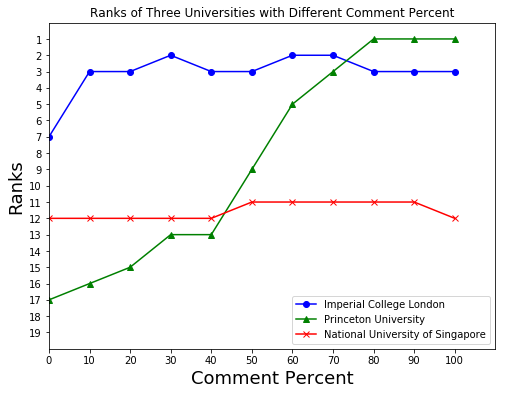

In [21]:
drawDiagram(QSScores,commentsScores)